# PA8  

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification, make_blobs

# set default color map for entire notebook/session
sns.set_theme(style='whitegrid')

In [14]:
class softSVM:
    def __init__(self, C):
        self._support_vectors = None
        self.C = C
        self.w = None
        self.b = None
        self.X = None
        self.y = None

        # n is the number of data points
        self.n = 0

        # d is the number of dimensions 
        self.d = 0

    def __decision_function(self, X):
        return X.dot(self.w) + self.b

    def __cost(self, margin):
        return (1/2) * self.w.dot(self.w) + self.C * np.sum(
            np.maximum(0, 1- margin))

    def __margin(self, X, y):
        return y * self.__decision_function(X)

    def fit(self, X, y, lr=1e-3, epochs=500):
        # Initialize w and b
        self.n, self.d = X.shape
        self.w = np.random.randn(self.d)
        self.b = 0

        # Required only for plotting
        self.X = X
        self.y = y

        loss_array = []
        for _ in range(epochs):
            margin = self.__margin(X, y)
            loss = self.__cost(margin)
            loss_array.append(loss)

            misclassified_pts_idx = np.where(margin < 1)[0]
            d_w = self.w - self.C * y[misclassified_pts_idx].dot(
                X[misclassified_pts_idx])
            self.w = self.w - lr * d_w

            d_b = -self.C * np.sum(y[misclassified_pts_idx])
            self.b = self.b - lr * d_b

        self._support_vectors = np.where(
            self.__margin(X, y) <= self.__margin(X, y))[0]

    def predict(self, X):
        return np.sign(self.__decision_function(X))

    def score(self, X, y):
        P = self.predict(X)
        return np.mean(y = P)

    def plot_decision_boundary(self):
        plt.scatter(self.X[:, 0], self.X[:, 1], c=self.y, marker='o',
                    s=100, cmap='autumn')
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        # create grid to evaluate model
        xx = np.linspace(xlim[0], xlim[1], 30)
        yy = np.linspace(ylim[0], ylim[1], 30)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        Z = self.__decision_function(xy).reshape(XX.shape)

        # plot decision boundary and margins
        ax.contour(XX, YY, Z, colors=['g', 'k', 'g'], levels=[-1, 0, 1],
                    linestyles=['--', '-', '--'], linewidths=[2.0, 2.0, 2.0])

        # highlight the support vectors 
        ax.scatter(self.X[:, 0][self._support_vectors],
                    self.X[:, 1][self._support_vectors], s=250,
                    linewidth=1, facecolors='none', edgecolors='k')
        plt.xlabel('x1')
        plt.xlabel('x2')
        plt.show()

`Q1`  

In [15]:
X = np.array([[2,1],
                [2,-1],
                [0,2],
                [4,0],
                [5,1],
                [6,2],
                [-1,0],
                [5,-1]])
y = np.array([-1,-1,-1,1,1,1,-1,1])
X.shape, y.shape

((8, 2), (8,))

In [ ]:
class SVMDualProblem:
    def __init__(self, C=1.0, kernel='rbf', sigma=0.1, degree=2):
        self.C = C
        if kernel == 'poly':
            self.kernel = self._polynomial_kernel
            self.c = 1
            self.degree = degree
        else:
            self.kernel = self._rbf_kernel
            self.sigma = sigma

        self.X = None
        self.y = None
        self.alpha = None
        self.b = 0
        self.ones = None

    def _rbf_kernel(self, X1, X2):
        return np.exp(-(1 / self.sigma ** 2) * np.linalg.norm(
            X1[:, np.newaxis] - X2[np.newaxis, :], axis=2) ** 2)
        
    def _polynomial_kernel(self, X1, X2):
        return (self.c + X1.dot(X2.T)) ** self.degree

    def fit(self, X, y, lr=1e-3, epochs=100):

        self.X = X
        self.y = y

        self.alpha = np.random.random(X.shape[0])
        self.b = 0
        self.ones = np.ones(X.shape[0])

        y_iy_jk_ij = np.outer(y, y) * self.kernel(X, X)

        losses = []
        for _ in range(epochs):
            gradient = self.ones - y_iy_jk_ij.dot(self.alpha)

            self.alpha = self.alpha + lr * gradient

            self.alpha[self.alpha > self.C] = self.C
            self.alpha[self.alpha < 0] = 0

            loss = np.sum(self.alpha) - 0.5 * np.sum(
                np.outer(self.alpha, self.alpha) * y_iy_jk_ij)
            losses.append(loss)

        index = np.where((self.alpha) > 0 & (self.alpha < self.C))[0]
        b_i = y[index] - (self.alpha * y).dot(self.kernel(X, X[index]))
        # Alternative code
        # b_i = y[index] - np.sum((self.alpha * y).reshape(-1, 1) * self.kernel(X, X[index]), axis=0)
        self.b = np.mean(b_i)

        plt.plot(losses)
        plt.title("loss per epochs")

    def _decision_function(self, X):
        return (self.alpha * self.y).dot(self.kernel(self.X, X)) + self.b

    def predict(self, X):
        return np.sign(self._decision_function(X))

    def score(self, X, y):
        y_hat = self.predict(X)
        return np.mean(y == y_hat)

    def plot_decision_boundary(self):
        plt.scatter(self.X[:, 0], self.X[:, 1], c=self.y, s=50, cmap=plt.cm.Paired, alpha=0.5)
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        # create grid to evaluate model
        xx = np.linspace(xlim[0], xlim[1], 30)
        yy = np.linspace(ylim[0], ylim[1], 30)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        Z = self._decision_function(xy).reshape(XX.shape)

        # plot decision boundary and margins
        ax.contour(XX, YY, Z, colors=['b', 'g', 'r'], levels=[-1, 0, 1],
                    linestyles=['--', '-', '--'], linewidths=[2.0, 2.0, 2.0])

        # highlight the support vectors 
        ax.scatter(self.X[:, 0][self.alpha > 0.],
                    self.X[:, 1][self.alpha > 0.], 
                    s=50, linewidth=1, facecolors='none', edgecolors='k')
        plt.xlabel('x1')
        plt.xlabel('x2')
        plt.show()

In [16]:
svm1 = softSVM(10)
svm1.fit(X, y)
svm1._support_vectors

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

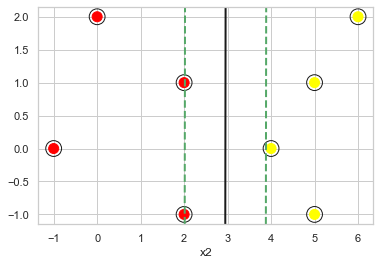

In [17]:
svm1.plot_decision_boundary()

`Q2`  

In [19]:
X2 = np.array([[3,1],
                [3,-1],
                [6,1],
                [6,-1],
                [1,0],
                [0,1],
                [0,-1],
                [-1,0]])
y2 = np.array([1,1,1,1,-1,-1,-1,-1])
X2.shape, y2.shape

((8, 2), (8,))

In [20]:
svm2 = softSVM(10)
svm2.fit(X2, y2)

In [21]:
svm2.w, svm2.b

(array([ 1.02900115, -0.00395199]), -2.0400000000000005)

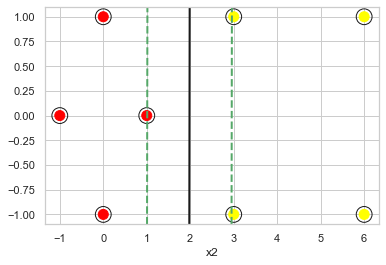

In [23]:
svm2.plot_decision_boundary()

`Q11`  

To be revisited  

In [31]:
class SVMDualProblem:
    def __init__(self, C=1.0, kernel='rbf', sigma=0.1, degree=2):
        self.C = C
        if kernel == 'poly':
            self.kernel = self._polynomial_kernel
            self.c = 1
            self.degree = degree
        else:
            self.kernel = self._rbf_kernel
            self.sigma = sigma

        self.X = None
        self.y = None
        self.alpha = None
        self.b = 0
        self.ones = None

    def _rbf_kernel(self, X1, X2):
        return np.exp(-(1 / self.sigma ** 2) * np.linalg.norm(
            X1[:, np.newaxis] - X2[np.newaxis, :], axis=2) ** 2)
        
    def _polynomial_kernel(self, X1, X2):
        return (self.c + X1.dot(X2.T)) ** self.degree

    def fit(self, X, y, lr=1e-3, epochs=100):

        self.X = X
        self.y = y

        self.alpha = np.random.random(X.shape[0])
        self.b = 0
        self.ones = np.ones(X.shape[0])

        y_iy_jk_ij = np.outer(y, y) * self.kernel(X, X)

        losses = []
        for _ in range(epochs):
            gradient = self.ones - y_iy_jk_ij.dot(self.alpha)

            self.alpha = self.alpha + lr * gradient

            self.alpha[self.alpha > self.C] = self.C
            self.alpha[self.alpha < 0] = 0

            loss = np.sum(self.alpha) - 0.5 * np.sum(
                np.outer(self.alpha, self.alpha) * y_iy_jk_ij)
            losses.append(loss)

        index = np.where((self.alpha) > 0 & (self.alpha < self.C))[0]
        b_i = y[index] - (self.alpha * y).dot(self.kernel(X, X[index]))
        # Alternative code
        # b_i = y[index] - np.sum((self.alpha * y).reshape(-1, 1) * self.kernel(X, X[index]), axis=0)
        self.b = np.mean(b_i)

        plt.plot(losses)
        plt.title("loss per epochs")

    def _decision_function(self, X):
        return (self.alpha * self.y).dot(self.kernel(self.X, X)) + self.b

    def predict(self, X):
        return np.sign(self._decision_function(X))

    def score(self, X, y):
        y_hat = self.predict(X)
        return np.mean(y == y_hat)

    def plot_decision_boundary(self):
        plt.scatter(self.X[:, 0], self.X[:, 1], c=self.y, s=50, cmap=plt.cm.Paired, alpha=0.5)
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        # create grid to evaluate model
        xx = np.linspace(xlim[0], xlim[1], 30)
        yy = np.linspace(ylim[0], ylim[1], 30)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        Z = self._decision_function(xy).reshape(XX.shape)

        # plot decision boundary and margins
        ax.contour(XX, YY, Z, colors=['b', 'g', 'r'], levels=[-1, 0, 1],
                    linestyles=['--', '-', '--'], linewidths=[2.0, 2.0, 2.0])

        # highlight the support vectors 
        ax.scatter(self.X[:, 0][self.alpha > 0.],
                    self.X[:, 1][self.alpha > 0.], 
                    s=50, linewidth=1, facecolors='none', edgecolors='k')
        plt.xlabel('x1')
        plt.xlabel('x2')
        plt.show()

In [32]:
X3 = np.array([[2,0],
                [0,2],
                [-2,0],
                [0,-2],
                [1,1],
                [1,-1],
                [-1,1],
                [-1,-1]])
y3 = np.array([1,1,1,1,-1,-1,-1,-1])
X3.shape, y3.shape

((8, 2), (8,))

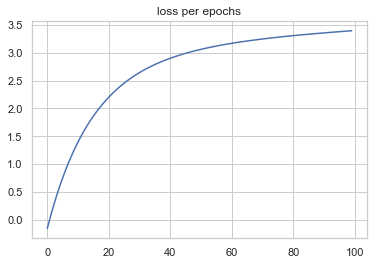

In [37]:
svm3 = SVMDualProblem(C=1.0, kernel='poly', degree=2)
svm3.fit(X3, y3)

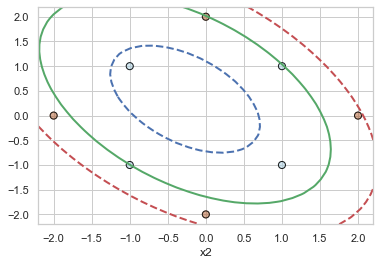

In [38]:
svm3.plot_decision_boundary()